# Libraries

In [1]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display, HTML
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('always')

# Loading Data

In [3]:
fake= pd.read_csv("Fake.csv")
true= pd.read_csv("True.csv")

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake.drop(columns=["title","date","subject"],inplace=True)
true.drop(columns=["title","date","subject"],inplace=True)

In [6]:
true['label'] = 0
fake['label'] = 1

In [7]:
print(f"Fake News : {fake.shape}")
print(f"Real News : {true.shape}")

Fake News : (23481, 2)
Real News : (21417, 2)


# Make Data Balanced

In [9]:
df_real = true.sample(21417, random_state=2000)
df_fake = fake.sample(21417, random_state=2000)

In [10]:
df = pd.concat([df_real, df_fake])

In [11]:
df =df.sample(frac=1, random_state=2000).reset_index(drop=True)

In [12]:
print(f"Balanced dataset shape : {df.shape}")

Balanced dataset shape : (42834, 2)


# Display Sample Of Data

In [14]:
def styled_heading(text, background_color='#4a90e2', text_color='white'):
    return f"""<p style="background-color: {background_color};
        font-family: Trebuchet MS, sans-serif;
        font-size: 130%;
        color: {text_color};
        text-align: center;
        border-radius: 8px;
        padding: 8px;
        font-weight: bold;
        box-shadow: 0px 2px 6px rgba(0, 0, 0, 0.25);
        width: fit-content;
        margin: 10px auto;">
        {text}
    </p>"""
def style_table(df, header_color='#4a90e2'):
    styled_df = df.style.set_table_styles([{"selector": "th", "props": [("color", "white"), ("background-color", header_color),("font-weight", "bold"), ("text-align", "center")]}
    ]).set_properties(**{"text-align": "center", "border": "1px solid #ddd", "padding": "5px"}) \
     .hide(axis="index")
    return styled_df.to_html()

def show_sample_and_counts(df, n_top=5, heading_color='#4a90e2', text_color='white'):
    sample_heading = styled_heading("Sample from Dataset", heading_color, text_color)
    display(HTML(sample_heading))
    display(HTML(style_table(df.head(n_top), header_color=heading_color)))

    counts_heading = styled_heading("Label Distribution", heading_color, text_color)
    display(HTML(counts_heading))
    counts_df = df['label'].value_counts().rename_axis('Label').reset_index(name='Count')
    display(HTML(style_table(counts_df, header_color=heading_color)))
def check_duplicates(df, heading_color='#4a90e2', text_color='white'):
    dup_heading = styled_heading(" Duplicate ", heading_color, text_color)
    display(HTML(dup_heading))

    dup_count = df.duplicated().sum()
    if dup_count > 0:
        dup_df = pd.DataFrame({"Duplicate Rows": [dup_count]})
        display(HTML(style_table(dup_df, header_color=heading_color)))
    else:
        display(HTML("<p style='text-align:center; color:green; font-weight:bold;'> No duplicate rows found.</p>"))


In [15]:
show_sample_and_counts(df,n_top=6,heading_color='#2c3e50', text_color='white')
check_duplicates(df, heading_color='#2c3e50', text_color='white')

text,label
"WASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell on Wednesday dashed any remaining hopes that President Barack Obama’s signature Pacific-Rim trade deal would come up for a vote before President-elect Donald Trump takes office in January. “It’s certainly not going to be brought up this year,” McConnell said of the 12-country Trans-Pacific Partnership (TPP) at a news briefing in Washington. McConnell said any decisions on TPP or other future trade agreements would be up to Trump, who would still have the authority for four more years to negotiate “better deals” with expedited approval procedures in Congress. Trump excoriated TPP on the campaign trail as a “disaster” and “a rape of our country,” tapping into populist anger at globalization, trade and manufacturing job losses that helped propel his candidacy. In an opinion piece published on Monday, Trump advisers Peter Navarro and Alexander Gray reiterated his opposition to major trade deals. “Trump will never again sacrifice the U.S. economy on the altar of foreign policy by entering into bad trade deals like the North American Free Trade Agreement, allowing China into the World Trade Organization, and passing the proposed TPP,” Navarro and Gray wrote in Foreign Policy magazine. “These deals only weaken our manufacturing base and ability to defend ourselves and our allies.” The Obama administration has been promoting TPP among lawmakers and industry groups in anticipation of a long-shot, post-election vote despite opposition to the deal by Trump and his Democratic opponent, Hillary Clinton. While there are many Republican supporters of free trade and TPP in Congress, McConnell and House of Representatives Speaker Paul Ryan said on Wednesday they were now focused on laying the groundwork with Trump to pass Republican-focused healthcare and tax reform legislation next year. A spokeswoman for Ryan said he had not had a change of heart since he said on a radio talk show in October that the House would not bring TPP up for a vote because of problems with several provisions and insufficient support in the House. McConnell said his priorities for the post-election “lame-duck” session were passing a government funding extension and medical innovation legislation. White House spokesman Josh Earnest was still trying to sell the TPP agreement in a news briefing on Wednesday. “President Obama does continue to believe that this is the best opportunity that the Congress has to take advantage of the benefits of a Trans-Pacific Partnership agreement that cuts taxes, 18,000 taxes, that other countries impose on American products,” Earnest told reporters. “We’ve got a strong case to make.” But the strong vote for Trump in industrial states made it unlikely Republicans would be willing to go against him on trade policy, analysts said. “It’s fair to say that TPP is now in the dustbin of history,” said Gary Hufbauer, a senior fellow at the Peterson Institute for International Economics, a pro-trade think tank in Washington. “I don’t see a path forward for the United States to join.”",0
"CARACAS (Reuters) - Venezuela on Monday accused U.S. President Donald Trump of conducting political terrorism through travel restrictions on eight countries including the socialist-run South American nation, which is already at loggerheads with Washington. Trump on Sunday announced the restrictions on citizens from North Korea, Venezuela and Chad, expanding earlier travel bans that Trump says are necessary to fight terrorism but have been derided by critics and courts. It is worth pointing out that these types of lists are incompatible with international law, and constitute a form of psychological and political terrorism, the Foreign Ministry said in a statement. Our people are being sanctioned because of their pacifist nature as well as their tolerance and respect for different religions and beliefs, it added. The statement said Venezuela will consider all necessary measures to protect 

Label,Count
0,21417
1,21417


Duplicate Rows
5325


# Preprocessing

In [17]:
df[df['text'].isna() | (df['text'].str.strip() == '')].sum()

text                                                   ...
label                                                  582
dtype: object

In [18]:
df = df.drop(df[df['text'].isna() | (df['text'].str.strip() == '')].index)
df.shape

(42251, 2)

In [19]:
news = df.drop_duplicates().copy()
news.shape

(37506, 2)

In [20]:
def cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>',' ', text)
    text = re.sub(r'[^a-zA-Z]',' ', text)
    text = re.sub(r'\s+',' ', text).strip()
    return text

In [21]:
def Tokenization(text):
    return word_tokenize(text)

In [22]:
def lowercase(text):
    return[tokens.lower() for tokens in text]

In [23]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return[word for word in tokens if word not in stop_words]

In [24]:
lemmatizer=WordNetLemmatizer()
def lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [25]:
def preprocessing(text):
    text= cleaning(text)
    tokens= Tokenization(text)
    tokens= lowercase(tokens)
    tokens= remove_stopwords(tokens)
    tokens= lemmatization(tokens)
    return " ".join(tokens)

In [26]:
news["processed"]=news["text"].apply(preprocessing)
news.head()

,text,label,processed
0,WASHINGTON (Reuters) - U.S. Senate Majority Le...,0,washington reuters u senate majority leader mi...
1,CARACAS (Reuters) - Venezuela on Monday accuse...,0,caracas reuters venezuela monday accused u pre...
2,WASHINGTON (Reuters) - A Democratic and a Repu...,0,washington reuters democratic republican congr...
4,WASHINGTON (Reuters) - The United States pulle...,0,washington reuters united state pulled regiona...
5,"Given how vile Trump s treatment of women is, ...",1,given vile trump treatment woman absolute wond...


# Visualization Most Common Words

In [28]:
fake_freq = pd.Series(" ".join(news[news['label']==1]['processed']).split()).value_counts()
true_freq = pd.Series(" ".join(news[news['label']==0]['processed']).split()).value_counts()

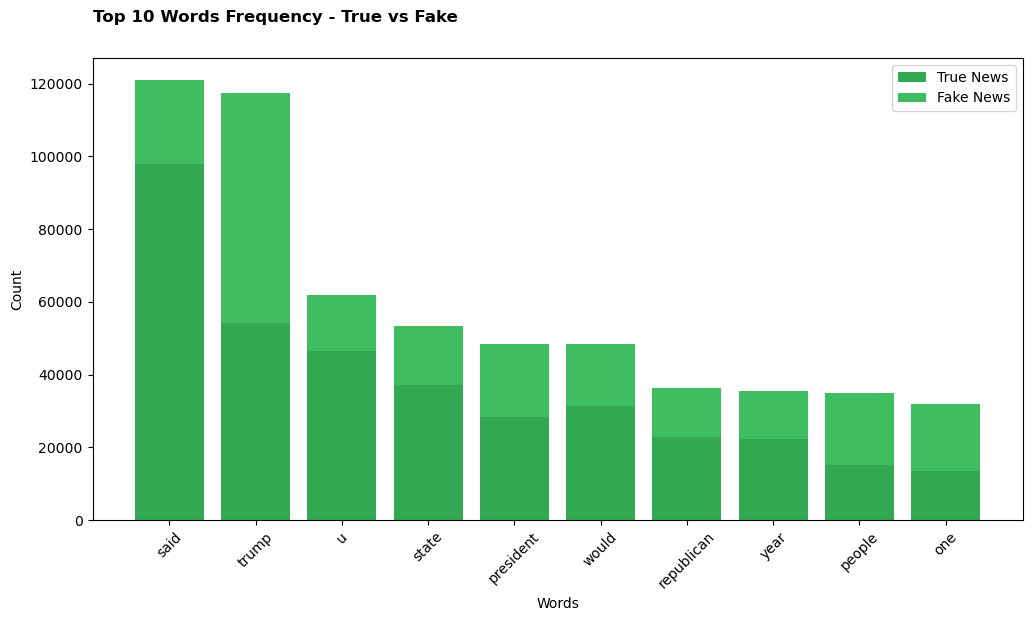

In [29]:
top_words = (fake_freq + true_freq).sort_values(ascending=False).head(10).index

y1 = [true_freq.get(word, 0) for word in top_words]
y2 = [fake_freq.get(word, 0) for word in top_words]

plt.figure(figsize=(12,6))
plt.bar(top_words, y1, label="True News", color="#32a852")
plt.bar(top_words, y2, bottom=y1, label="Fake News", color="#3ebd61")
plt.title("Top 10 Words Frequency - True vs Fake", loc="left", fontdict={"weight": "bold"}, y=1.06)
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(loc="upper right")

Text(0.5, 1.0, 'WordCloud - True News')

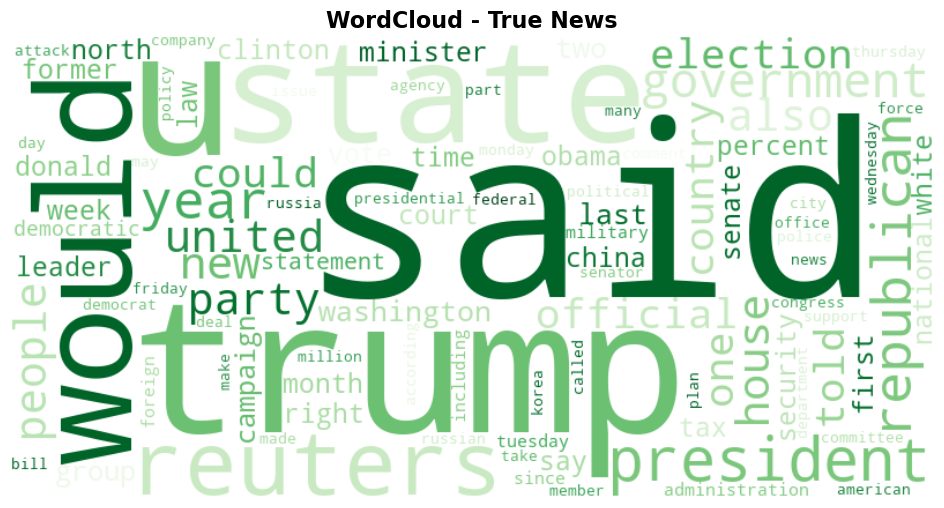

In [30]:
true_freq_dict = true_freq.to_dict()
wc_true = WordCloud(width=800,height=400,background_color="white",colormap="Greens",max_words=100).generate_from_frequencies(true_freq_dict)

plt.figure(figsize=(12,6))
plt.imshow(wc_true, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - True News", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'WordCloud - Fake News')

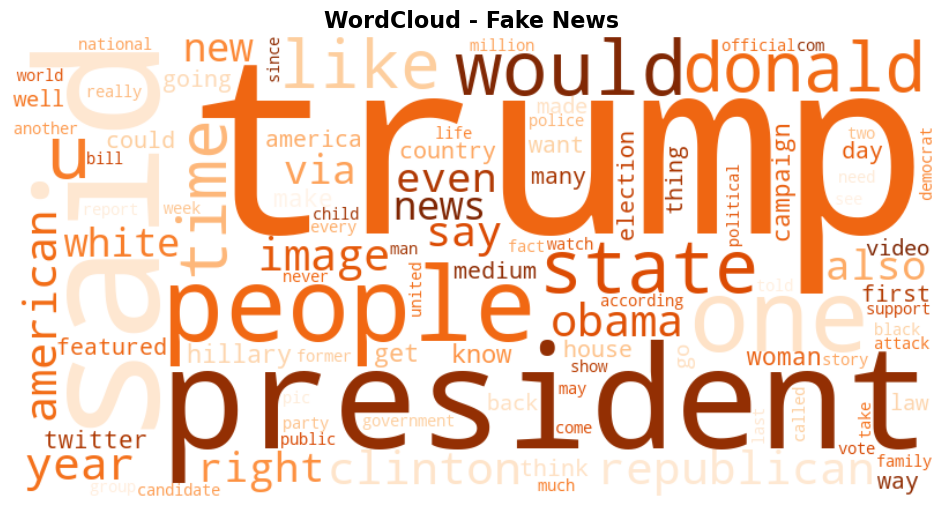

In [31]:
fake_freq_dict = fake_freq.to_dict()
wc_fake = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Oranges",
    max_words=100).generate_from_frequencies(fake_freq_dict)

plt.figure(figsize=(12,6))
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Fake News", fontsize=16, fontweight="bold")

# BoW

In [33]:
bow=CountVectorizer()
x_bow=bow.fit_transform(news['processed'])
print("first 10 word: ", bow.get_feature_names_out()[:10])
print("shape: ", x_bow.shape)

first 10 word:  ['aa' 'aaa' 'aaaaaaaand' 'aaaaapkfhk' 'aaaahhhh' 'aaaand' 'aaab' 'aaarf'
 'aab' 'aaba']
shape:  (37506, 100449)


# TF-IDF

In [36]:
tfidf = TfidfVectorizer(min_df=2)
x_tfidf = tfidf.fit_transform(news['processed'])
print("First 10 words: ", tfidf.get_feature_names_out()[:10])
print("Shape: ", x_tfidf.shape)

First 10 words:  ['aa' 'aaa' 'aabge' 'aachen' 'aadhaar' 'aaf' 'aahd' 'aal' 'aamer' 'aamin']
Shape:  (37506, 51045)


In [37]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Split DataSet

In [259]:
y=news["label"]

In [261]:
X_train,X_test,y_train,y_test=train_test_split(x_tfidf,y, test_size=0.2, random_state=42,stratify=y)

# Logistic Model

In [264]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred =log_model.predict(X_test)

# Random Forest Model

In [267]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Confusion Matrix

In [279]:
def plot_confusion(y_true, y_pred, labels=["True News","Fake News"], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title, fontweight="bold")

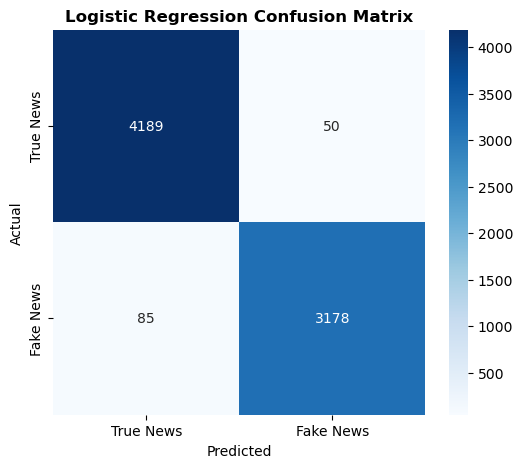

In [285]:
plot_confusion(y_test, log_pred, title="Logistic Regression Confusion Matrix")

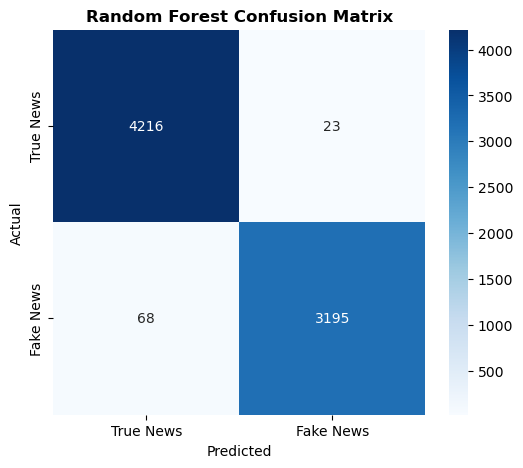

In [287]:
plot_confusion(y_test, rf_pred, title="Random Forest Confusion Matrix")

# Evaluate Models

In [270]:
def evaluate_heatmap(y_true, y_pred, name):
    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    
    report_df = pd.DataFrame(report_dict).iloc[:-1, :].T  # نتجاهل row support
    print("\nClassification Report:\n", report_df)
    
    plt.figure(figsize=(8,5))
    sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"{name} Classification Report Heatmap", fontweight="bold")


Logistic Regression Evaluation
Accuracy: 0.9820047987203412
Precision: 0.9845105328376704
F1 Score: 0.979201971961177

Classification Report:
               precision    recall  f1-score
0              0.980112  0.988205  0.984142
1              0.984511  0.973950  0.979202
accuracy       0.982005  0.982005  0.982005
macro avg      0.982311  0.981078  0.981672
weighted avg   0.982025  0.982005  0.981993


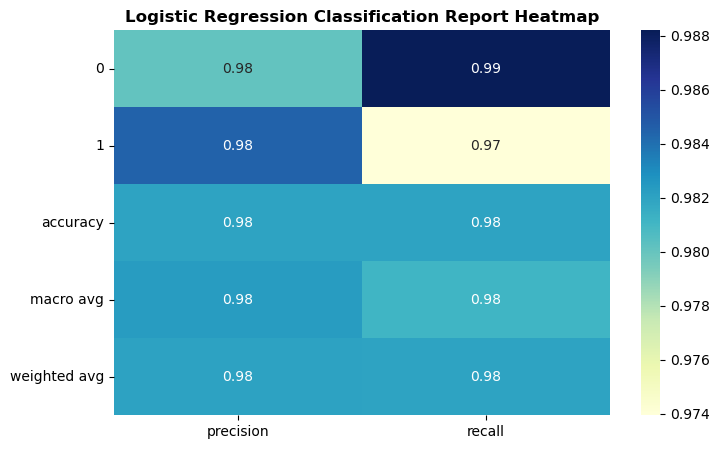

In [274]:
evaluate_heatmap(y_test,log_pred,"Logistic Regression")


Random Forest Evaluation
Accuracy: 0.9878699013596375
Precision: 0.992852703542573
F1 Score: 0.9859589569510878

Classification Report:
               precision    recall  f1-score
0              0.984127  0.994574  0.989323
1              0.992853  0.979160  0.985959
accuracy       0.987870  0.987870  0.987870
macro avg      0.988490  0.986867  0.987641
weighted avg   0.987922  0.987870  0.987860


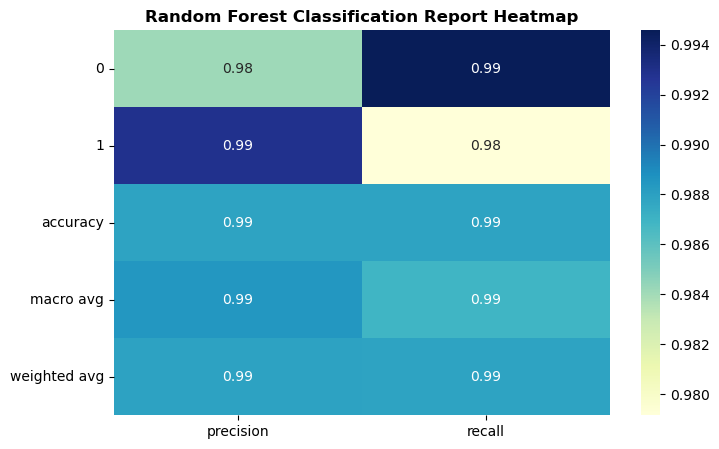

In [276]:
evaluate_heatmap(y_test,rf_pred,"Random Forest")

# Comparison

In [290]:
accuracy_log = accuracy_score(y_test, log_pred)
accuracy_rf = accuracy_score(y_test, rf_pred)
print("Accuracy - Logistic Regression:", round(accuracy_log, 4))
print("Accuracy - Random Forest:", round(accuracy_rf, 4))

Accuracy - Logistic Regression: 0.982
Accuracy - Random Forest: 0.9879


# Saving Random Forest Model

In [295]:
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)